# Finding the features of an Image using SIFT Transform

Total Number of SIFT Features in the Input Image: 1964


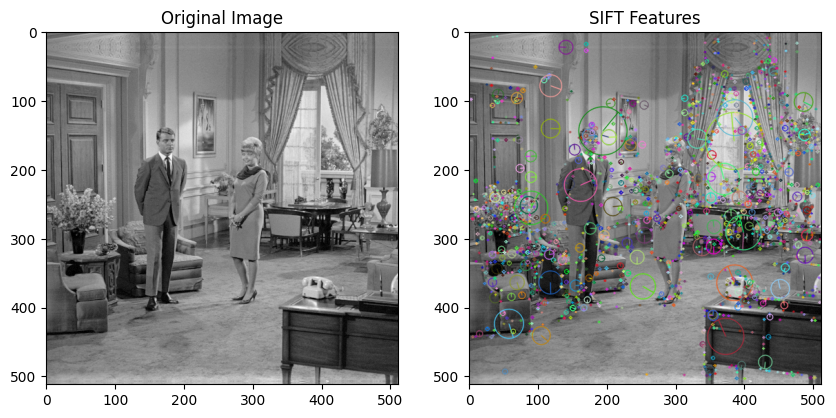

In [ ]:
import cv2
from matplotlib import pyplot as plt

fig=plt.figure(figsize=(10,10))

image1=cv2.imread('/content/drive/MyDrive/Colab Notebooks/Standard Images/livingroom.tif')
image1=cv2.cvtColor(image1,cv2.COLOR_BGR2GRAY)

#creating the sift object and finding the keypoints
sift=cv2.SIFT_create()
keypoints=sift.detect(image1,None)

#drawing the keypoints
#None to mark the keypoints on image2
#flag to determine how the keypoint is visualized
#cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS shows the scale and orientation of each keypoint
image2=cv2.drawKeypoints(image1,keypoints,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fig.add_subplot(121)
plt.imshow(image1,cmap='gray')
plt.title("Original Image")

fig.add_subplot(122)
plt.imshow(image2,cmap='gray')
plt.title("SIFT Features")

print("Total Number of SIFT Features in the Input Image:",len(keypoints))

Total Number of SIFT Features in the Input Image 1: 1670
Total Number of SIFT Features in the Input Image 2: 1460


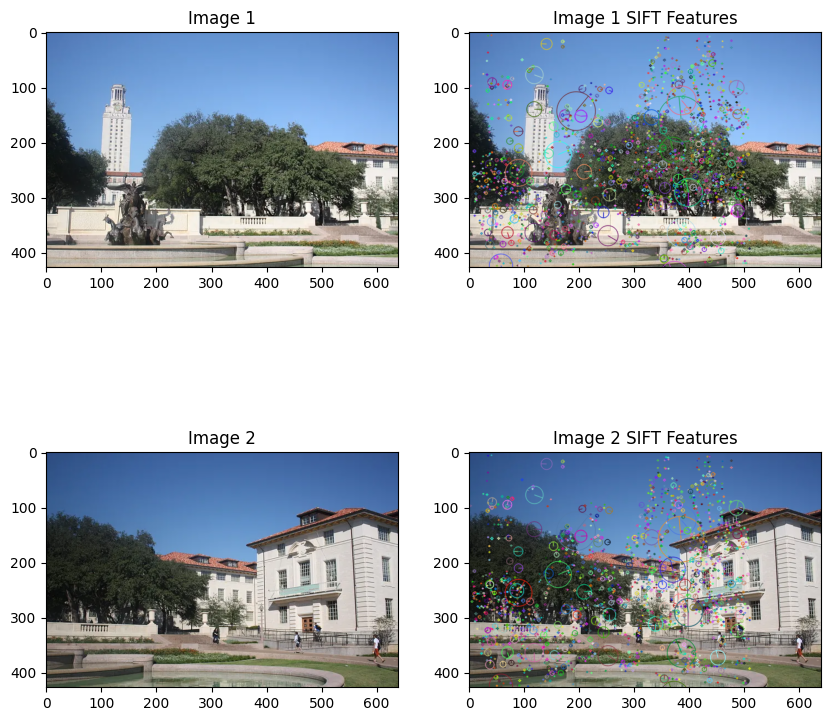

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

fig=plt.figure(figsize=(10,10))

image1=cv2.imread('/content/drive/MyDrive/Colab Notebooks/Standard Images/pan21.webp')
image1=cv2.cvtColor(image1,cv2.COLOR_BGR2RGB)

image2=cv2.imread('/content/drive/MyDrive/Colab Notebooks/Standard Images/pan22.webp')
image2=cv2.cvtColor(image2,cv2.COLOR_BGR2RGB)

#creating the sift object and finding the keypoints
sift=cv2.SIFT_create()
keypoints1,descriptors1=sift.detectAndCompute(image1,None)
keypoints2,descriptors2=sift.detectAndCompute(image2,None)

#drawing the keypoints
#None to mark the keypoints on image2
#flag to determine how the keypoint is visualized
#cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS shows the scale and orientation of each keypoint
image1_2=cv2.drawKeypoints(image1,keypoints,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
image2_2=cv2.drawKeypoints(image2,keypoints,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fig.add_subplot(221)
plt.imshow(image1)
plt.title("Image 1")

fig.add_subplot(222)
plt.imshow(image1_2)
plt.title("Image 1 SIFT Features")

fig.add_subplot(223)
plt.imshow(image2)
plt.title("Image 2")

fig.add_subplot(224)
plt.imshow(image2_2)
plt.title("Image 2 SIFT Features")

print("Total Number of SIFT Features in the Input Image 1:",len(keypoints1))
print("Total Number of SIFT Features in the Input Image 2:",len(keypoints2))

In [ ]:
#match the 2 images
#the good matches are described in a homography matrix
#homography matrix describes the transformations between 2 images taken in different viewpoints
#a 3x3 matrix, describes the transformations from one plane to another

def matcher(keypoints1,keypoints2,descriptors1,descriptors2,image1,image2):
  #BFMatcher is Brute Force Matcher which maps one descriptor to the other descriptors and finds the best matches
  bf=cv2.BFMatcher()
  matches=bf.knnMatch(descriptors1,descriptors2,k=2)#will give the closest 2 matches for each descriptor

  #giving a threshold value of 0.5 for calculating the best matches
  good=[]
  #a distance ratio test is performed here
  #a match if considered if the distance is less than 50% of the distance from j
  for i,j in matches:
    if i.distance < 0.5*j.distance:
      good.append([i])

  #using values from good[], the homography matrix is formed
  src_pts = np.float32([keypoints1[m[0].queryIdx].pt for m in good]).reshape(-1, 1, 2)
  dst_pts = np.float32([keypoints2[m[0].trainIdx].pt for m in good]).reshape(-1, 1, 2)

  H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

  #to get the coordinates(pt) of each keypoints and then appends it to matches
  matches=[]
  for pair in good:
    matches.append(list(keypoints1[pair[0].queryIdx].pt +keypoints2[pair[0].trainIdx].pt))

  matches=np.array(matches)
  return matches,H

matches,H=matcher(keypoints1,keypoints2,descriptors1,descriptors2,image1,image2)
#print(matches)
print(H)

[[ 1.30236343e+00 -7.32412258e-02 -3.60088738e+02]
 [ 1.71430447e-01  1.22415290e+00 -1.06232708e+02]
 [ 4.51732725e-04  3.80503415e-05  1.00000000e+00]]


In [ ]:
print(matches[0])

[298.58279419 263.51928711   8.49319935 233.24238586]


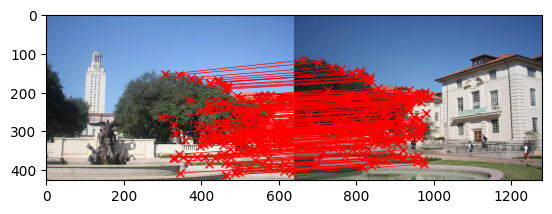

In [ ]:
#plotting the matches

images=np.concatenate((image1,image2),axis=1)
match_image=images.copy()

offset=images.shape[1]/2
fig,ax=plt.subplots()
ax.imshow(np.array(match_image).astype('uint8'))
ax.plot(matches[:,0],matches[:,1],'xr')
ax.plot(matches[:,2] + offset, matches[:,3],'xr')
ax.plot([matches[:,0], matches[:,2] + offset], [matches[:, 1],matches[:, 3]], 'r', linewidth=0.5)
plt.show()

In [ ]:
print(len(matches))

192


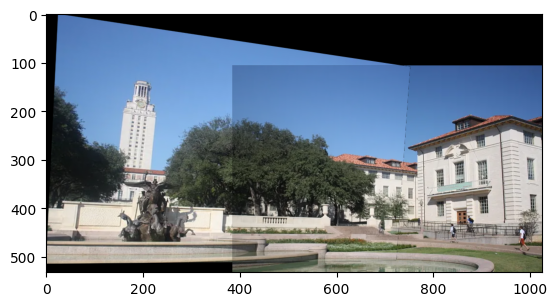

In [ ]:
#stitching the 2 images

#converting the images to double and normalizing it
image1=cv2.normalize(image1.astype('float'),None,0.0,1.0,cv2.NORM_MINMAX)
image2=cv2.normalize(image2.astype('float'),None,0.0,1.0,cv2.NORM_MINMAX)

#considering the first image
height1,width1,channel1=image1.shape
corners=[[0,0,1],[width1,0,1],[width1,height1,1],[0,height1,1]]#for homography matrix
corners_new=[np.dot(H, corner) for corner in corners]#applying H to each corner point to get the transformed points
corners_new=np.array(corners_new).T

#normalization of transformed corners
x_news=corners_new[0] / corners_new[2]
y_news = corners_new[1] / corners_new[2]
#calculating the minimum coordinates for translation
y_min = min(y_news)
x_min = min(x_news)

#translation matrix
translation_matrix=np.array([[1,0,-x_min],[0,1,-y_min],[0,0,1]])
H=np.dot(translation_matrix,H)

#getting the new height and width
height_new=int(round(abs(y_min)+height1))
width_new=int(round(abs(x_min)+width1))
size=(width_new,height_new)

#taking the first image and warping with H
#cv2.warpPerspective applies a perspective transformation to an image
warped1=cv2.warpPerspective(image1,H,size)

height2,width2,channel2=image2.shape

height_new=int(round(abs(y_min)+height2))
width_new=int(round(abs(x_min)+width2))
size=(width_new,height_new)

#taking the second image and warping with translation matrix
warped2=cv2.warpPerspective(image2,translation_matrix,size)

#for black pixel
black=np.zeros(3)

#stitching and storing in warped1
for i in range(warped2.shape[0]):
  for j in range(warped2.shape[1]):
    pixel1=warped1[i ,j , :]#pixel from warped1 is taken
    pixel2=warped2[i,j,:]#pixel from warped2 is taken

    #if warped1 is non balck and warped2 is black, pixel1 is still used for warped1
    if not np.array_equal(pixel1,black) and np.array_equal(pixel2,black):
      warped1[i,j,:]=pixel1
    #considering pixel2 if warped1 pixel is black and warped2 pixel is valid
    elif np.array_equal(pixel1,black) and not np.array_equal(pixel2,black):
      warped1[i,j,:]=pixel2
    #if both the values are valid, an average of both the pixels are considered
    elif not np.array_equal(pixel1,black) and not np.array_equal(pixel2,black):
      warped1[i,j,:]=(pixel1+pixel2)/2

stitched_image=warped1[:warped2.shape[0], :warped2.shape[1], :]

plt.imshow(stitched_image)